In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras import layers,models
import tensorflow as tf
from tensorflow import keras

In [2]:
# It will load the image dataset from potato 
# directory and then convert image into soze of 256*256 and then make 
# batches of 32 
from random import shuffle
IAMGE_SIZE = 256
BATCH_SIZE =32

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "potato",
    shuffle=True,
    image_size = (IAMGE_SIZE,IAMGE_SIZE),
    batch_size = BATCH_SIZE

)

Found 2152 files belonging to 3 classes.


In [3]:
# classes of potato images 
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [4]:
# as the dataset is divided into 3 classes with batsize 32 32 images each
len(dataset)

68

In [5]:
for image_batch , label_batch in dataset.take(1):
    # There are 32 images in an batch each of 256 * 256 and rgb of 3
    print(image_batch.shape)
    # print 1 st image 
    #print(image_batch[0])
    print(image_batch[0].numpy())#convert tensor to image
    print(label_batch.numpy())

(32, 256, 256, 3)
[[[200. 195. 192.]
  [199. 194. 191.]
  [197. 192. 189.]
  ...
  [197. 193. 194.]
  [198. 194. 195.]
  [200. 196. 197.]]

 [[200. 195. 192.]
  [198. 193. 190.]
  [195. 190. 187.]
  ...
  [196. 192. 193.]
  [194. 190. 191.]
  [194. 190. 191.]]

 [[199. 194. 191.]
  [196. 191. 188.]
  [193. 188. 185.]
  ...
  [197. 193. 194.]
  [195. 191. 192.]
  [192. 188. 189.]]

 ...

 [[138. 129. 132.]
  [134. 125. 128.]
  [129. 120. 123.]
  ...
  [150. 144. 148.]
  [154. 148. 152.]
  [154. 148. 152.]]

 [[133. 124. 127.]
  [135. 126. 129.]
  [130. 121. 124.]
  ...
  [154. 148. 152.]
  [161. 155. 159.]
  [162. 156. 160.]]

 [[126. 117. 120.]
  [135. 126. 129.]
  [135. 126. 129.]
  ...
  [152. 146. 150.]
  [157. 151. 155.]
  [155. 149. 153.]]]
[0 1 1 1 0 0 0 1 0 1 1 0 0 1 1 0 0 0 2 0 1 0 0 0 0 1 1 0 1 1 1 2]


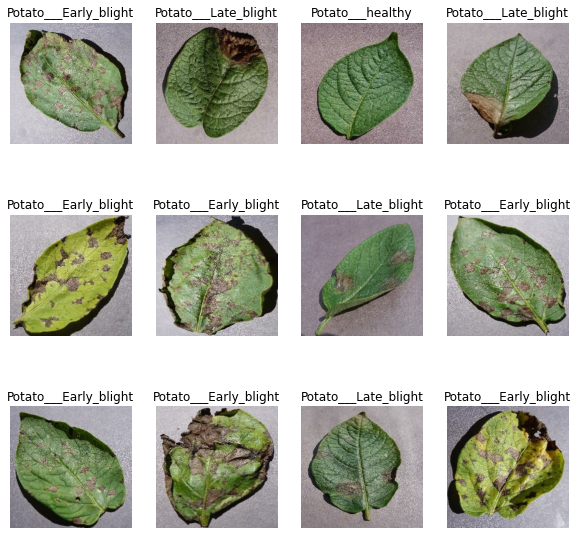

In [6]:
plt.figure(figsize=(10,10))
for image_batch , label_batch in dataset.take(1):
    #Showing 12 images
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

We will set 80% data as training 
20 % == 10% as validation and 10 % as test

In [7]:
def get_datset_partitiond_tf(ds,train_split = 0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds


In [8]:
train_ds,val_ds,test_ds = get_datset_partitiond_tf(dataset)

In [9]:
# Cache read the image from disk and for next iteration it will keep the image in memory 
# So that impovrs the performance of the pipeline
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)


In [10]:
resize_and_rescale = keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Resizing(IAMGE_SIZE,IAMGE_SIZE),
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
    ])

In [11]:
data_augmentation = keras.Sequential([
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
    ])

Model Building 

In [19]:
CHANNELS = 3
input_shape = (BATCH_SIZE,IAMGE_SIZE , IAMGE_SIZE,CHANNELS )
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    #filter soze is 3*3
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),
])
model.build(input_shape=input_shape)

In [20]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_16 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_16 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_17 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                 

In [22]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [24]:
history = model.fit(
    train_ds,
    epochs=50,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds
)

Epoch 1/50
54/54 [==============================] - 147s 2s/step - loss: 0.8408 - accuracy: 0.5712 - val_loss: 0.6682 - val_accuracy: 0.6667
Epoch 2/50
54/54 [==============================] - 110s 2s/step - loss: 0.4092 - accuracy: 0.8304 - val_loss: 0.4492 - val_accuracy: 0.8385
Epoch 3/50
54/54 [==============================] - 107s 2s/step - loss: 0.2633 - accuracy: 0.8993 - val_loss: 0.3408 - val_accuracy: 0.8646
Epoch 4/50
54/54 [==============================] - 107s 2s/step - loss: 0.2789 - accuracy: 0.8889 - val_loss: 0.2891 - val_accuracy: 0.8906
Epoch 5/50
54/54 [==============================] - 105s 2s/step - loss: 0.1946 - accuracy: 0.9306 - val_loss: 0.2247 - val_accuracy: 0.9062
Epoch 6/50
54/54 [==============================] - 120s 2s/step - loss: 0.1899 - accuracy: 0.9277 - val_loss: 0.4316 - val_accuracy: 0.8333
Epoch 7/50
54/54 [==============================] - 112s 2s/step - loss: 0.1779 - accuracy: 0.9294 - val_loss: 0.1705 - val_accuracy: 0.9531
Epoch 8/50
54

In [25]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 20s 502ms/step - loss: 0.1562 - accuracy: 0.9570


In [27]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [28]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [29]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Traninig and Validation Accuracy')

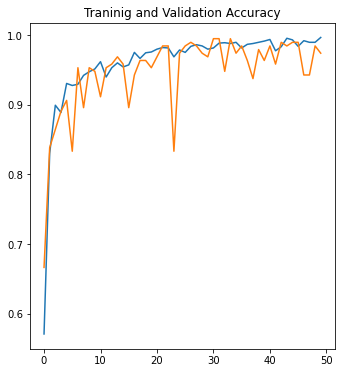

In [42]:
EPOCHS =50


plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='Training Accuracy')
plt.plot(range(EPOCHS),val_acc,label='VAlidation Accuracy')
plt.title('Traninig and Validation Accuracy')



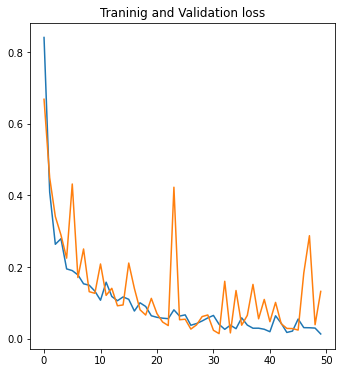

In [43]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),loss,label='Training loss')
plt.plot(range(EPOCHS),val_loss,label='VAlidation loss')
plt.title('Traninig and Validation loss')
plt.show()